In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
fake = pd.read_csv("C:/Users/gane0/Videos/fake news/Fake.csv")
true = pd.read_csv("C:/Users/gane0/Videos/fake news/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,FOUR CANDIDATES FOR FBI DIRECTOR Interviewed T...,Four candidates for FBI Director are being int...,Government News,"May 13, 2017",fake
1,Factbox: Contenders for key jobs in Trump's ad...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,"November 22, 2016",true
2,"Arabs, Europe, U.N. reject Trump's recognition...",LONDON (Reuters) - Arabs and Muslims across th...,worldnews,"December 6, 2017",true
3,Democrats want a law to stop Trump from bombin...,WASHINGTON (Reuters) - Democratic U.S. senator...,politicsNews,"October 31, 2017",true
4,Syrian army seizes oilfield from Islamic State...,BEIRUT (Reuters) - The Syrian army and its all...,worldnews,"September 9, 2017",true


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,FOUR CANDIDATES FOR FBI DIRECTOR Interviewed T...,Four candidates for FBI Director are being int...,Government News,fake
1,Factbox: Contenders for key jobs in Trump's ad...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,true
2,"Arabs, Europe, U.N. reject Trump's recognition...",LONDON (Reuters) - Arabs and Muslims across th...,worldnews,true
3,Democrats want a law to stop Trump from bombin...,WASHINGTON (Reuters) - Democratic U.S. senator...,politicsNews,true
4,Syrian army seizes oilfield from Islamic State...,BEIRUT (Reuters) - The Syrian army and its all...,worldnews,true


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Four candidates for FBI Director are being int...,Government News,fake
1,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,true
2,LONDON (Reuters) - Arabs and Muslims across th...,worldnews,true
3,WASHINGTON (Reuters) - Democratic U.S. senator...,politicsNews,true
4,BEIRUT (Reuters) - The Syrian army and its all...,worldnews,true


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,four candidates for fbi director are being int...,Government News,fake
1,(reuters) - u.s. president-elect donald trump ...,politicsNews,true
2,london (reuters) - arabs and muslims across th...,worldnews,true
3,washington (reuters) - democratic u.s. senator...,politicsNews,true
4,beirut (reuters) - the syrian army and its all...,worldnews,true


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,four candidates for fbi director are being int...,Government News,fake
1,reuters us presidentelect donald trump held a...,politicsNews,true
2,london reuters arabs and muslims across the m...,worldnews,true
3,washington reuters democratic us senators int...,politicsNews,true
4,beirut reuters the syrian army and its allies...,worldnews,true


In [14]:
data.head()

,text,subject,target
0,four candidates for fbi director are being int...,Government News,fake
1,reuters us presidentelect donald trump held a...,politicsNews,true
2,london reuters arabs and muslims across the m...,worldnews,true
3,washington reuters democratic us senators int...,politicsNews,true
4,beirut reuters the syrian army and its allies...,worldnews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


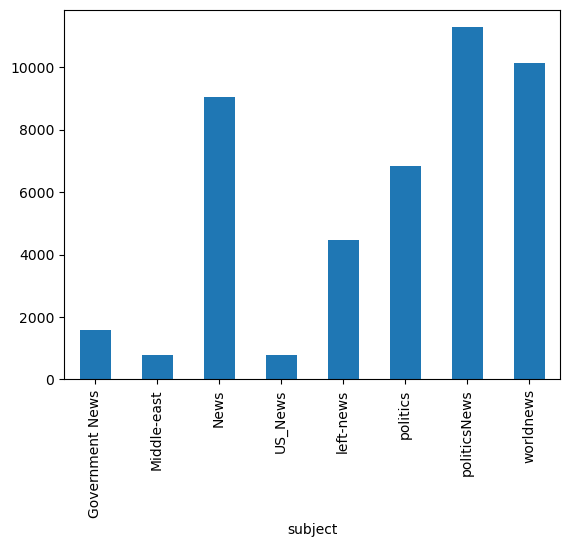

In [15]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


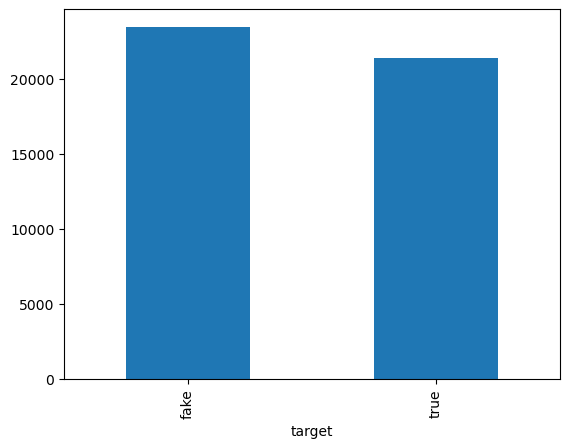

In [16]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

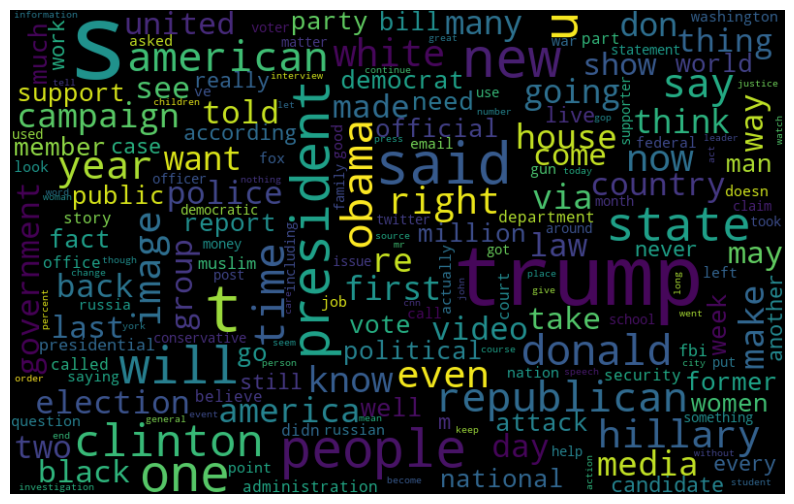

In [17]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

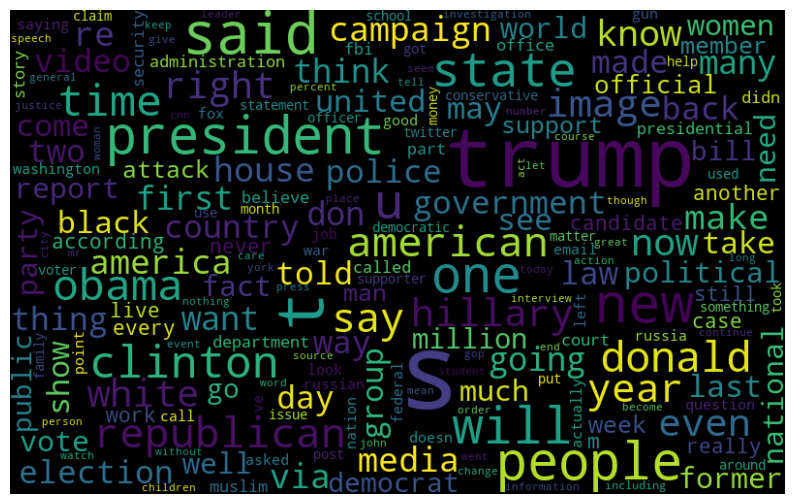

In [18]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

In [20]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

NameError: name 'nltk' is not defined

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [ ]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [ ]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# **Naive Bayes**




In [ ]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [ ]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

In [ ]:
the end.....